<a href="https://colab.research.google.com/github/yylonly/ServeNet/blob/stacked-bert/ServeNet/ServeNet_TF1.5_Keras_TPU_GoogleDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!kill -9 -1

In [0]:
SavePrefix='TF-Keras-TPU-GoolgeDrive'


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

if os.path.isdir("/content/drive/My Drive/ServeNet"):
  os.chdir("/content/drive/My Drive/ServeNet")
else: 
  !git clone https://github.com/yylonly/ServeNet.git
  os.chdir("/content/drive/My Drive/ServeNet")

In [0]:
!ls -l 

total 56
drwx------ 2 root root 4096 Nov 22 16:59 AdaBoost_Net
drwx------ 2 root root 4096 Nov 22 16:59 Colab
drwx------ 2 root root 4096 Nov 26 15:08 Data
-rw------- 1 root root  311 Nov 22 16:59 Dockerfile
drwx------ 2 root root 4096 Nov 22 16:59 LDA_SVM_Net
drwx------ 2 root root 4096 Nov 22 16:59 Naive_Bayes_Net
drwx------ 2 root root 4096 Nov 22 16:59 Random_Forest_Net
-rw------- 1 root root 1794 Nov 22 16:59 README.md
drwx------ 2 root root 4096 Nov 22 16:59 Result
drwx------ 2 root root 4096 Nov 22 16:59 ServeNet
-rw------- 1 root root 3031 Nov 23 16:09 ServeNetHistory
-rw------- 1 root root 1191 Nov 23 16:09 ServeNetLoss.pdf
-rw------- 1 root root 1191 Nov 23 16:09 ServeNetTop1.pdf
-rw------- 1 root root 1191 Nov 23 16:09 ServeNetTop5.pdf
-rw------- 1 root root 1487 Nov 26 14:58 TF-Keras-TPU-GoolgeDrive-ServeNetHistory
-rw------- 1 root root 1191 Nov 26 14:58 TF-Keras-TPU-GoolgeDrive-ServeNetLoss.pdf
-rw------- 1 root root 1191 Nov 26 14:58 TF-Keras-TPU-GoolgeDriveServeNetTop1.

In [0]:
# compatible with keras

from tensorflow import keras
import numpy as np
import os

import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 1.15.0


In [0]:
# Detect hardware
# tf.keras.backend.clear_session()
# tf.reset_default_graph()

# resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.1.71.194:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.1.71.194:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15974936447426035621)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4145356314974468720)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11122739602206450324)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10871791738329850188)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/devic

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras import metrics
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import Orthogonal



Using TensorFlow backend.


In [0]:
h5f = h5py.File('Data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:8064].astype(np.int32)
Y_train = h5f['Train_Y_one_hot'][:8064].astype(np.int32)
X_test = h5f['indexed_padded_Test_X'][:2048].astype(np.int32)
Y_test = h5f['Test_Y_one_hot'][:2048].astype(np.int32)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8064, 110) (8064, 50)
(2048, 110) (2048, 50)


In [0]:
batch_size = 128
step = len(X_train) // batch_size

In [0]:
step*64

4032

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
if not os.path.isfile("Data/glove.6B.200d.txt"):
  !wget http://nlp.stanford.edu/data/glove.6B.zip -P Data
  !unzip Data/glove.6B.zip -d Data

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('Data/glove.6B.200d.txt')

In [0]:
vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    # embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer


In [0]:
vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
print(vocab_len)
emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
print(emb_dim)

400001
200


In [0]:
# val_top_k_categorical_accuracy: 0.8845

def ServeNet(input_shape):
    """
    Function creating the ServeNet model
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='float32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    # embedding_layer = trainable_embedding_layer()
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_len, output_dim=emb_dim)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 


    embeddings = Reshape((110, 200, 1))(embeddings)
    
    features1 = Conv2D(64, kernel_size=(3, 3), padding='same')(embeddings)
    features2 = Conv2D(1, kernel_size=(1, 1), padding='same')(features1)
    features = Reshape((110, 200))(features2)
     
    print(features)
      
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(512, return_sequences=False))(features)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(200, activation='tanh')(X)
    X = Dropout(0.2)(X)
    X = Dense(50, activation='softmax', dtype='float32')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
checkpointer = ModelCheckpoint(filepath='Data/ServeNet-' + SavePrefix + '.hdf5', monitor='val_top_k_categorical_accuracy', verbose=1, save_best_only=True)

In [0]:
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)

In [0]:
maxLen = 110
with strategy.scope():
    model = ServeNet((maxLen, ))
    # model = lstm_model(seq_len=maxLen, stateful=False)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    model.layers[1].set_weights([emb_matrix])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("reshape_1/Reshape:0", shape=(?, 110, 200), dtype=float32)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 110, 200)          80000200  
_________________________________________________________________
reshape (Reshape)            (None, 110, 200, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 110, 200, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 200, 1)       65        
_________________________________________________________________
reshape_1 (Reshape)          (None, 110, 200)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              292044

In [0]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, steps_per_epoch=step, verbose = 1, callbacks=[checkpointer])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
16/16 [==============================] - 11s 677ms/step

Epoch 00001: val_top_k_categorical_accuracy improved from -inf to 0.66211, saving model to Data/ServeNet-TF-Keras-TPU-GoolgeDrive.hdf5
63/63 [==============================] - 40s 642ms/step - loss: 3.2926 - top_k_categorical_accuracy: 0.4315 - categorical_accuracy: 0.1687 - val_loss: 2.4982 - val_top_k_categorical_accuracy: 0.6621 - val_categorical_accuracy: 0.3403
Epoch 2/10
16/16 [==============================] - 16s 1s/step

Epoch 00002: val_top_k_categorical_accuracy improved from 0.66211 to 0.80127, saving model to Data/ServeNet-TF-Keras-TPU-GoolgeDrive.hdf5
16/16 [==============================] - 21s 1s/step

Epoch 00003: val_top_k_categorical_accuracy improved from 0.80127 to 0.85498, saving model to Data/ServeNet-TF-Keras-TPU-GoolgeDrive.hdf5
63/63 [==============================] - 43s 676ms/step - loss: 1.5914 - t

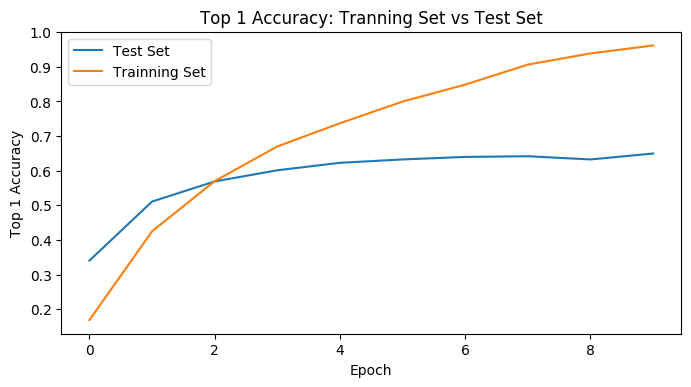

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + 'ServeNetTop1.pdf', format='pdf', dpi=300)

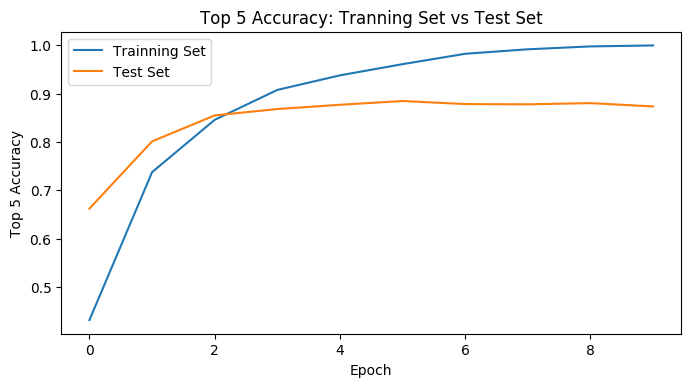

<Figure size 432x288 with 0 Axes>

In [0]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetTop5.pdf', format='pdf', dpi=300)

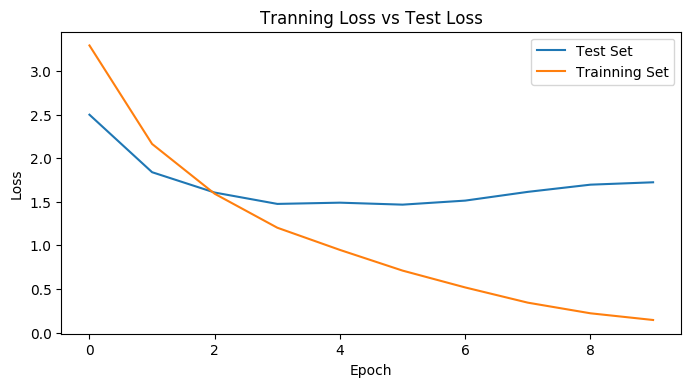

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetLoss.pdf', format='pdf', dpi=300)

In [0]:
import pickle
  
f = open(SavePrefix + '-ServeNetHistory', 'wb')
pickle.dump(history.history, f)
f.close()

In [0]:
import pickle

f = open(SavePrefix + '-ServeNetHistory', 'rb')
his = pickle.load(f)
f.close()

In [0]:
val_top_k = his['val_top_k_categorical_accuracy']
print("top5: ", max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print("loss: ", min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print("top1: ", max(val_ca))
print(np.argmax(val_ca))

top5:  0.8847656
5
loss:  1.4667315036058426
5
top1:  0.64941406
9


In [0]:
model = load_model('Data/ServeNet-' + SavePrefix + '.hdf5')

In [0]:
print("Training set:")
loss_train, top5error_train, top1error_train = model.evaluate(X_train, Y_train)
print("Top5 Training accuracy = ", top5error_train)
print("Top1 Training accuracy = ", top1error_train)
print('Test set:')
loss_test, top5error_test, top1error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)
print("Top1 Training accuracy = ", top1error_test)

Training set:
8064/8064 [==============================] - 33s 4ms/sample - loss: 0.3692 - top_k_categorical_accuracy: 0.9903 - categorical_accuracy: 0.8953
Top5 Training accuracy =  0.99032736
Top1 Training accuracy =  0.8953373
Test set:
2048/2048 [==============================] - 7s 3ms/sample - loss: 1.4666 - top_k_categorical_accuracy: 0.8848 - categorical_accuracy: 0.6323
Training accuracy =  0.8847656
Top1 Training accuracy =  0.6323242
